In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

In [3]:
import requests
import random

In [4]:
load_dotenv()

True

In [5]:
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [8]:
# Tools

search_tool = DuckDuckGoSearchRun(region = "us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmatic operatoin on two numbers.
    Supported operation: add, sub, mul, div
    """

    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by Zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f" Unsupported operation '{operation}'"}
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result} 
    except Exception as e:
        return {"error": str(e)}
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA')
    using Alpha vantage with API key in  the url
    """       

    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=22TSBZ2018712L9I"
    r = requests.get(url)
    return r.json()

In [9]:
# make tool list

tools = [get_stock_price, search_tool, calculator]

# make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [11]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [12]:
# graph nodes

# 1st node
def chat_node(state: ChatState):
    """ LLM node that may answer or request a tool call. """
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 2nd node
tool_node = ToolNode(tools)   # Execute tool calls

In [20]:
# graph structure

graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [21]:
graph.add_edge(START, 'chat_node')

# if the LLM asked for a tool, go to ToolNode, else finish
graph.add_conditional_edges("chat_node", tools_condition)

# updated code for a loop of tools and llm

graph.add_edge("tools", "chat_node")

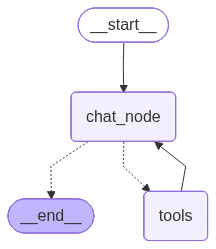

In [22]:
chatbot = graph.compile()
chatbot

In [23]:
def chat_with_bot(message:str):
    out = chatbot.invoke({"messages": [HumanMessage(content = message)]})
    print(out["messages"][-1].content)

In [24]:
chat_with_bot("heyo")

Hello! How can I help you today?


In [25]:
chat_with_bot("what is the stock price of apple")

The stock price of Apple is $254.63.


In [26]:
chat_with_bot('What is the stock price of apple and multiply it to 100')

The stock price of Apple is 254.63 and multiplied by 100 is 25463.
